# Do Zero ao Som: Criando Áudio Digital com Python

In [4]:
# Rode a célula se estiver no Google Colab
# from google.colab import output
# output.enable_custom_widget_manager()
# !pip install ipympl

In [5]:
# Importe as dependências

import numpy as np
import matplotlib.pyplot as plt
%matplotlib ipympl
from IPython.display import Audio, display
import ipywidgets as widgets
from ipywidgets import interactive
from scipy.io import wavfile
from scipy import signal
from abc import ABC, abstractmethod

In [6]:
# Vamos definir algumas variáveis globais
SR = 44100
DEFAULT_AMP = 1.0
DEFAULT_DUR = 1.0
DEFAULT_FREQ = 220

## Introdução

> *Como o computador processa uma música digitalmente?*
>
> *Como podemos entender uma representação digital de um sinal de áudio?*
>
> *Como sintetizadores digitais são desenvolvidos?*

Neste workshop, vamos entender um pouco sobre o que é um sinal de áudio digital e como podemos criar sons a partir do zero utilizando Python. Tudo isso de maneira interativa e prática.

Divirta-se!

## Som e Sinal

Vamos ganhar uma intuição inicial sobre o que é som e o que é sinal sonoro. Essas definições são importantes para entendermos o que estamos fazendo quando mexemos com áudio digital. A síntese sonora digital é uma área fascinante que combina ciência, tecnologia e arte para criar e manipular sons de maneiras inovadoras.

### O que é som?

**Som** é um fenômeno físico que ocorre quando moléculas de ar (ou outro meio elástico) se comprimem e rarefazem rapidamente.

Alto-falantes, por exemplo, movem-se para frente e para trás rapidamente, comprimindo e rarefazendo o ar, criando som. Por sua vez, nossos ouvidos são capazes de captar essas variações de pressão do ar e transformá-las em sinais elétricos que são enviados ao nosso cérebro.

Podemos modelar esse movimento do ar com a ajuda de computadores e da matemática. Isso nos permite não apenas reproduzir sons naturais, mas também criar sons completamente sintéticos.

### O que é sinal sonoro?

Um **sinal sonoro** pode ser entendido como uma função matemática que descreve a variação de pressão do ar ou tensão elétrica ao longo do tempo. Podemos visualizar um sinal sonoro com um gráfico onde o eixo horizontal representa o tempo e o eixo vertical representa a amplitude do som em cada instante de tempo. Essa representação gráfica é fundamental para a análise e manipulação de áudio digital.

Caso você nunca tenha visto a onda de uma música antes, observe o sinal dos primeiros 60 segundos da música "No Ordinary Love" da cantora Sade no software Ableton Live. Essa visualização ajuda a entender como diferentes sons e instrumentos contribuem para a textura geral de uma música.

> *This is no ordinary love...*

### Sinais analógicos e digitais

Consegue perceber que temos vários pontos no gráfico da onda sonora? Cada um desses pontos representa a intensidade do som em um instante de tempo.
Por isso, podemos dizer que esse sinal sonoro é **discreto** ou **digital**.

Mas o que diferencia um sinal digital de um sinal analógico? Vamos simplificar:

> Dizemos que um sinal sonoro é **analógico** quando a função está definida para todos os instantes no tempo. Em outras palavras, o sinal é **contínuo**. Sinais analógicos são aqueles que encontramos no mundo real, como o som que ouvimos naturalmente, e também em equipamentos de áudio tradicionais, como microfones e alto-falantes.

> Dizemos que um sinal sonoro é **digital** quando a função está definida apenas para uma lista finita de instantes no tempo, tornando o sinal **discreto**. Sinais digitais são utilizados em computadores e equipamentos digitais, permitindo o armazenamento e processamento eficiente de áudio.

Podemos imaginar um arquivo de áudio digital como uma **grande lista de números**, onde cada número representa a amplitude do som em um ponto específico no tempo.

In [7]:
# Carrega o arquivo de áudio e extrai o sample rate
sample_rate, audio_file = wavfile.read('Sade-No_Ordinary_Love-60s.wav')

# Mostra o tipo de dado armazenado no arquivo de áudio (NumPy Dtype)
print("Tipo de dado do arquivo de áudio:", audio_file.dtype) # int16, de [-32768, +32767]

# Imprime uma parte do arquivo de áudio
print("Algumas amostras do arquivo de áudio:", audio_file[480000:480000+10, 0]) # 10 amostras do canal esquerdo

Tipo de dado do arquivo de áudio: int16
Algumas amostras do arquivo de áudio: [-11313 -10939 -11831 -12245 -11796 -11042 -11059 -10910  -9690  -9067]


No exemplo acima, cada elemento da lista representa uma amplitude do som em um intervalo de inteiros de 16 bits, variando de -32768 a 32767. No entanto, ao processar áudio, é comum utilizarmos uma escala normalizada que varia de -1 a 1, facilitando cálculos e manipulações.

## Amostragem e Quantização

Agora que entendemos o que é um sinal sonoro digital, podemos explorar como ele é representado e processado em um computador. Para isso, precisamos definir algumas regras para a discretização nos eixos do tempo e da amplitude. Esses processos são conhecidos como amostragem e quantização.

### Amostragem

Amostragem é o processo de **discretização do sinal no eixo do tempo**. Imagine que você está tirando fotos de um evento contínuo em intervalos regulares; cada foto representa uma **amostra** do evento. Da mesma forma, na amostragem, capturamos a amplitude do som em intervalos de tempo regulares.

A **taxa de amostragem** é definida como o número de amostras capturadas por segundo, medida em **Hertz (Hz)**. Taxas de amostragem comuns incluem 44.1 kHz (usada em CDs de áudio), 48 kHz (usada em vídeos), e 96 kHz (usada em gravações de alta qualidade). Uma taxa de amostragem mais alta permite capturar mais detalhes do som, mas também requer mais espaço de armazenamento.

### Quantização

Quantização é o processo de **discretização do sinal no eixo da amplitude**. Após capturar as amostras, precisamos representar suas amplitudes em valores numéricos discretos.

A **resolução** da quantização é definida pelo número de níveis de amplitude possíveis, medido em **bits**. Resoluções comuns são 8 bits, 16 bits (usada em CDs de áudio), e 24 bits (usada em gravações profissionais). Uma resolução mais alta permite representar o som com maior precisão, reduzindo o ruído de quantização.

Agora que entendemos que um sinal sonoro digital é discretizado tanto no tempo quanto na amplitude, podemos ver como essas etapas são cruciais para a qualidade do áudio digital.

### Experimente Você Mesmo

Abaixo, você encontrará um ambiente interativo onde pode experimentar como uma onda senoidal muda com diferentes frequências, taxas de amostragem e resoluções. Isso permitirá que você veja em primeira mão como essas variáveis afetam a representação digital do som.


In [8]:
def visualiza_amostragem_e_quantizacao(SR=1000, bits=16, frequencia=DEFAULT_FREQ, amplitude=1.0, mostrar_continuo=False):
    # Parâmetros para visualização
    duracao = 1.0
    
    # Sinal contínuo (com mais pontos para parecer contínuo)
    t_continuo = np.linspace(0, duracao, 10000)
    sinal_continuo = np.sin(2 * np.pi * frequencia * t_continuo)
    
    # Amostragem do sinal contínuo
    t_amostrado = np.linspace(0, duracao, int(SR * duracao))
    onda = np.sin(2 * np.pi * frequencia * t_amostrado)
    
    # Quantização do sinal contínuo
    resolucao = 2**bits
    onda_quantizada = -1 + 2**(-bits) + 2*np.floor((resolucao-1e-8) * (0.5 + 0.5*onda)) / (resolucao)
    onda_quantizada *= amplitude
    
    # Cria o gráfico
    plt.figure(figsize=(16, 4))
    if mostrar_continuo:
        plt.plot(t_continuo, sinal_continuo, 'b-', label='Sinal Contínuo', alpha=0.5)
    plt.plot(t_amostrado, onda_quantizada, 'r.', label='Sinal Digital')
    plt.grid(True)
    plt.xlabel('Tempo (s)')
    plt.ylabel('Amplitude')
    plt.title(f'Senoide ({frequencia} Hz) - {SR} Hz de amostragem, {bits} bits de resolução')
    plt.legend()
    plt.show()
    
    # Mostra o player de áudio
    display(Audio(onda_quantizada, rate=SR, normalize=False))
    

# Cria a interface interativa
interactive_plot = interactive(
    visualiza_amostragem_e_quantizacao,
    SR=widgets.IntSlider(min=1, max=11200, step=10, value=100, description='Taxa de Amostragem (Hz):'),
    bits=widgets.IntSlider(min=1, max=24, step=1, value=16, description='Bits de Resolução:'),
    frequencia=widgets.IntSlider(min=1, max=440, step=1, value=1, description='Frequência (Hz):'),
    amplitude=widgets.FloatSlider(min=0.1, max=1.0, step=0.1, value=1.0, description='Amplitude:'),
    mostrar_continuo=widgets.Checkbox(value=False, description='Mostrar Sinal Contínuo')
)
display(interactive_plot)

interactive(children=(IntSlider(value=100, description='Taxa de Amostragem (Hz):', max=11200, min=1, step=10),…

## Percepção Sonora

Para ouvir algum som ao tocar o áudio, tente ajustar a frequência para, pelo menos, 80 Hz. O ouvido humano é capaz de ouvir sons em um intervalo de 20 a 20 mil Hertz (Hz), conhecido como o **espectro audível**. Dentro desse intervalo, nossa percepção sonora é influenciada por vários fatores, incluindo frequência, amplitude e o contexto em que o som é ouvido.

### Frequência e Altura

A frequência de um som determina sua **altura**, ou seja, se ele é percebido como **grave ou agudo**. Sons de baixa frequência, como o som de um tambor, são percebidos como graves, enquanto sons de alta frequência, como o canto de um pássaro, são percebidos como agudos.

### Amplitude e Volume

A amplitude de um som está relacionada à sua **intensidade ou volume**. Sons com maior amplitude são percebidos como mais altos, enquanto sons com menor amplitude são percebidos como mais baixos. O volume é geralmente medido em **decibéis (dB)**, uma escala logarítmica relativa que expressa a intensidade do som em relação a um nível de referência. Essa escala é útil porque o ouvido humano percebe mudanças de volume de forma proporcional, não linear.

No contexto de síntese sonora, é útil entender os diferentes tipos de dB utilizados:
- **dB SPL (Sound Pressure Level)**: Mede a pressão sonora em relação a um nível de referência no ar. É comumente usado para descrever o volume de sons no ambiente, sendo 0 dB SPL o limiar da audição humana, ou seja, o som mais fraco que o ouvido humano pode detectar. Sons audíveis possuem intensidade maior que 0 dB SPL.
- **dB FS (Full Scale)**: Usado em áudio digital, 0 dB FS representa o valor máximo que pode ser representado sem distorção (clipping). Qualquer valor acima de 0 dB FS resultará em distorção, pois o sistema não pode representar amplitudes maiores. À medida que a escala desce para -1 dB FS, -2 dB FS, e assim por diante, os valores representam amplitudes menores que não causam distorção. O som audível mais fraco em um sistema digital é determinado pelo menor valor representável, que depende da resolução em bits do sistema.

### Sensibilidade Auditiva

O ouvido humano não é igualmente sensível a todas as frequências. Somos mais sensíveis a frequências entre 2 kHz e 5 kHz, que coincidem com a faixa de frequências da fala humana. Essa sensibilidade variável explica por que certos sons são mais fáceis de ouvir do que outros, mesmo que tenham a mesma amplitude.

### Contexto e Experiência

A percepção sonora também é influenciada pelo contexto e pela experiência individual. Fatores como a acústica do ambiente, a presença de ruído de fundo e a familiaridade com o som podem afetar como percebemos e interpretamos o som.

## Espectro de frequência

O espectro de frequência é uma representação visual que mostra como a energia de um sinal sonoro é distribuída entre diferentes frequências. Imagine o espectro de frequência como um gráfico onde o eixo horizontal representa as frequências (medidas em Hertz) e o eixo vertical representa a amplitude ou intensidade dessas frequências.

Na síntese sonora, o espectro de frequência é usado para criar e manipular sons. Ao ajustar as frequências e suas amplitudes, podemos esculpir o som desejado, reforçando ou atenuando bandas de frequência graves ou agudas.

Veja uma implementação do espectro de frequência da música "No Ordinary Love", que carregamos anteriormente.

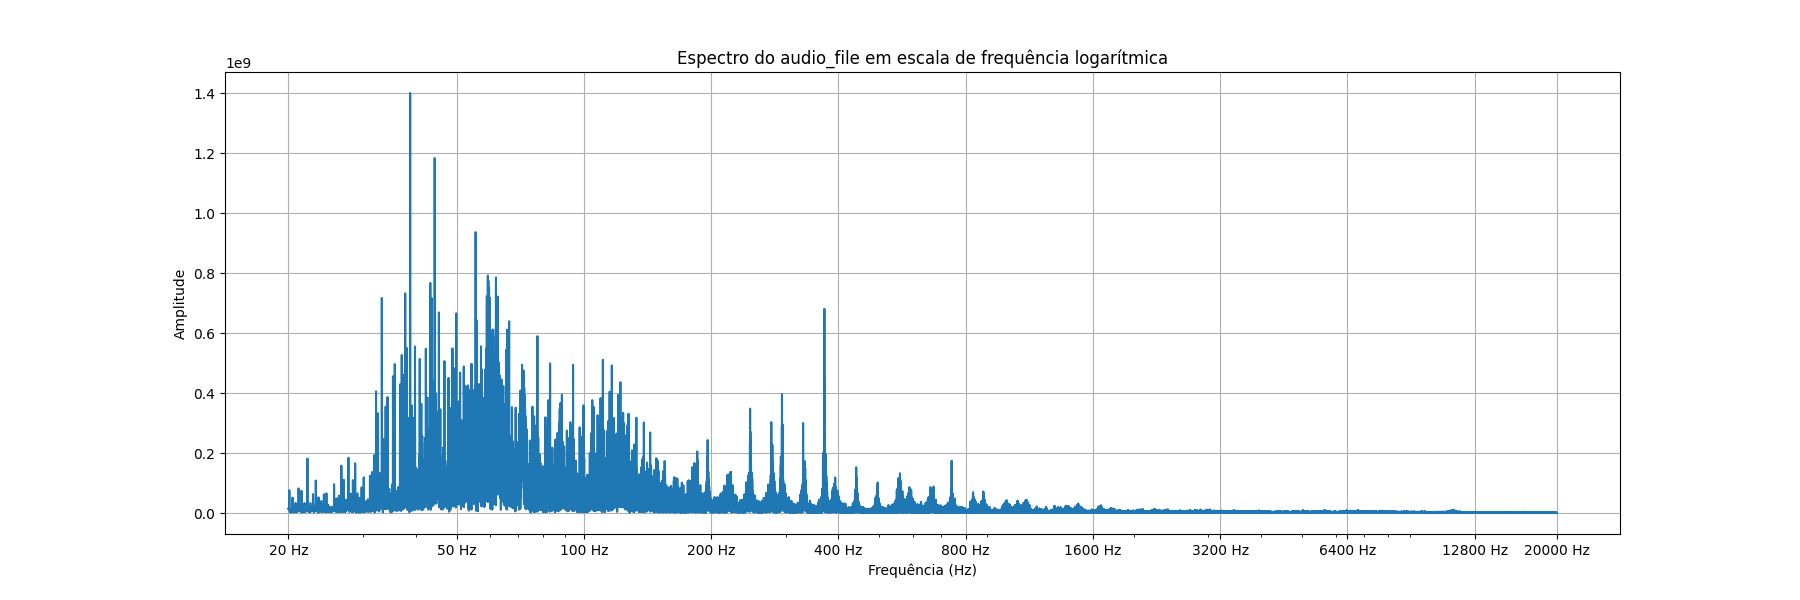

In [9]:
from scipy.fft import fft, fftfreq

def plot_audio_spectrum(audio, sample_rate):
    # Computa a FFT do áudio inteiro 
    N = len(audio)
    yf = fft(audio)
    xf = fftfreq(N, 1 / sample_rate)

    # Filtra frequências entre 20 e 20 kHz (espectro audível)
    mask = (xf >= 20) & (xf <= 20000)
    xf = xf[mask]
    yf = np.abs(yf[mask])

    # Define marcadores personalizados para frequências importantes para música 
    musical_frequencies = [20, 50, 100, 200, 400, 800, 1600, 3200, 6400, 12800, 20000]
    tick_labels = [f"{freq} Hz" for freq in musical_frequencies]

    # Cria o gráfico
    plt.figure(figsize=(18, 6))
    plt.semilogx(xf, yf)
    plt.title("Espectro do audio_file em escala de frequência logarítmica")
    plt.xlabel("Frequência (Hz)")
    plt.ylabel("Amplitude")
    plt.xticks(musical_frequencies, tick_labels)
    plt.grid()
    plt.show()

plot_audio_spectrum(audio_file[:, 0], sample_rate) # Plot do espectro do canal esquerdo

Vamos ver no Ableton Live uma implementação profissional de espectro de frequência.

> *This is no ordinary love...*

## Sinais elementares

Vamos estudar alguns sinais elementares: **ruídos** e **sinais periódicos**. Eles são a base para a construção de sons mais complexos (e mais interessantes).

In [10]:
# Vamos definir uma classe abstrata para a implementação dos ambientes interativos 
class AmbienteInterativoSintetizador(ABC):
    def __init__(self, sintetizador):
        self.sintetizador = sintetizador

    def cria_plot(self):
        plt.figure(figsize=(18, 6))
        plt.plot(self.sintetizador.eixo_tempo, self.sintetizador.sinal, 'b-')
        plt.grid(True)
        plt.xlabel('Tempo (s)')
        plt.ylabel('Amplitude')
        plt.ylim(-1.1, 1.1)
        plt.show()
        
    def cria_audio_player(self):
        display(Audio(self.sintetizador.sinal, rate=SR, normalize=False))
    
    @abstractmethod
    def callback():
        pass

In [11]:
# Vamos definir uma classe abstrata para a implementação dos sinais elementares
class Sintetizador(ABC):
    def __init__(self, amplitude=1.0, duracao=DEFAULT_DUR, frequencia=DEFAULT_FREQ):
        self.amplitude  = amplitude
        self.duracao    = duracao
        self.frequencia = frequencia
        self.sinal      = self.gerar()
        self.eixo_tempo = None

    @abstractmethod
    def gerar(self):
        pass
    
    @abstractmethod
    def cria_ambiente_interativo(self):
        pass

### Ruídos

No mundo do áudio, **ruído** não possui uma definição categórica, mas é comum entendê-lo como um sinal sonoro que:

- Não possui uma altura musical definida
- Não costuma ser periódico

Ruídos são caracterizados por sua **densidade espectral**, que é a distribuição de energia do sinal em função da frequência. Diferentes tipos de ruído são frequentemente identificados por "cores", como **branco, vermelho e rosa**, cada um com suas próprias características espectrais.

Vamos sintetizar e ouvir os ruídos branco e vermelho.

In [12]:
class AmbienteInterativoRuido(AmbienteInterativoSintetizador):
    def callback(self, amplitude, duracao):
        # Atualiza os parâmetros do sintetizador
        self.sintetizador.amplitude = amplitude
        self.sintetizador.duracao = duracao

        # Gera um novo sinal
        self.sintetizador.sinal = self.sintetizador.gerar()

        self.cria_plot()
        self.cria_audio_player()

In [16]:
class Ruido(Sintetizador):
    def cria_ambiente_interativo(self):
        ambiente = AmbienteInterativoRuido(self)
        interativo = interactive(
            ambiente.callback,
            amplitude=widgets.FloatSlider(min=0, max=1, step=0.1, value=self.amplitude, description="Amplitude:"),
            duracao=widgets.FloatSlider(min=0.1, max=1, step=0.1, value=self.duracao, description="Duração (s)"),
        )
        display(interativo)

**ATENÇÃO: ABAIXE (MUITO) O VOLUME DO SEU COMPUTADOR ANTES DE OUVIR OS ÁUDIOS.**

#### Ruído branco

O **ruído branco** é um sinal sonoro que possui energia **uniformemente distribuída em todas as frequências audíveis**. Isso significa que cada frequência dentro do espectro audível tem a mesma potência, resultando em um som constante e uniforme.

Você pode ter ouvido ruído branco em um rádio fora de sintonia ou em uma televisão sem sinal. Além desses exemplos, o ruído branco é frequentemente usado em testes de equipamentos de áudio para verificar a resposta em frequência.

Vamos sintetizar um ruído branco e ouvi-lo:

In [17]:
class RuidoBranco(Ruido):
    def gerar(self):
        # Gera o eixo do tempo
        self.eixo_tempo = np.linspace(0, self.duracao, int(SR * self.duracao))
        # Gera o sinal de ruído branco
        return np.random.uniform(-self.amplitude, self.amplitude, len(self.eixo_tempo))

In [18]:
ruido_branco = RuidoBranco(amplitude=DEFAULT_AMP, duracao=DEFAULT_DUR)
ruido_branco.cria_ambiente_interativo()

interactive(children=(FloatSlider(value=1.0, description='Amplitude:', max=1.0), FloatSlider(value=1.0, descri…

#### Ruído vermelho

O **ruído vermelho**, também conhecido como ruído Browniano ou ruído marrom, é um tipo de ruído que possui energia inversamente proporcional à frequência. Isso significa que ele tem mais energia em frequências baixas e menos energia em frequências altas, resultando em um som mais suave em comparação com o ruído branco.

Devido à sua ênfase em frequências mais baixas, o ruído vermelho é frequentemente percebido como mais agradável e menos intrusivo do que o ruído branco. Essa característica o torna útil em aplicações como a criação de ambientes sonoros relaxantes e em música eletrônica, onde um som mais encorpado e menos estridente é desejado.

Vamos sintetizar um ruído vermelho e ouvi-lo:

In [19]:
class RuidoVermelho(Ruido):
    def gerar(self):
        self.eixo_tempo = np.linspace(0, self.duracao, int(SR * self.duracao))

        amostras = int(SR * self.duracao)

        branco = np.random.uniform(-1, 1, amostras) # O ruído vermelho é derivado do ruído branco

        vermelho = np.zeros(1 * amostras)
        vermelho[0] = branco[0] # Inicializa a primeira amostra

        for i in range(1, amostras):
            vermelho[i] = branco[i] + vermelho[i - 1]

        vermelho = vermelho / np.max(np.abs(vermelho))
        
        vermelho = self.amplitude * vermelho # ajuste de amplitude

        return vermelho

In [20]:
ruido_vermelho = RuidoVermelho(amplitude=1.0, duracao=DEFAULT_DUR)
ruido_vermelho.cria_ambiente_interativo() 

interactive(children=(FloatSlider(value=1.0, description='Amplitude:', max=1.0), FloatSlider(value=1.0, descri…

#### *Qual a utilidade de ruídos na síntese sonora?*

Embora ruídos possam não ter um aspecto musical por si só, eles desempenham um papel crucial na síntese sonora. A partir de um ruído, podemos aplicar diversas técnicas, como filtros, envelopes e efeitos, para criar sons mais complexos e musicalmente interessantes.

Ruídos são frequentemente usados como base na criação de texturas sonoras, efeitos de percussão e ambiências. Por exemplo, ao utilizar envelopes ADSR, podemos moldar a dinâmica do som, transformando um ruído estático em um elemento musical dinâmico.

Vamos explorar essas técnicas mais adiante, quando discutirmos envelopes ADSR e outras ferramentas de modulação na síntese sonora.

### Sinais periódicos

Um sinal periódico possui como característica principal a repetição de um padrão de onda ao longo do tempo. Esse padrão pode ser chamado de **ciclo** ou **período**.

A **frequência** de um sinal periódico é o número de ciclos que se repetem em um segundo. Medimos a frequência em **Hertz** (Hz).

A percepção de frequência é o que chamamos de **altura** do som, ou seja, se o som é grave ou agudo. Como visto anteriormente, a percepção de frequência é o que chamamos de altura do som, ou seja, se o som é grave ou agudo.

Os sinais periódicos elementares são as **ondas senoidais**, **ondas quadradas**, **ondas dente-de-serra** e **ondas triangulares**, cada um com um formato de ciclo e característica tonal particular.

Vamos sintetizar e ouvir cada um desses sinais periódicos.

In [21]:
class AmbienteInterativoOnda(AmbienteInterativoSintetizador):
    def callback(self, amplitude, duracao, frequencia):
        # Atualiza os parâmetros do sintetizador
        self.sintetizador.amplitude = amplitude
        self.sintetizador.duracao = duracao
        self.sintetizador.frequencia = frequencia
        
        # Gera um novo sinal
        self.sintetizador.sinal = self.sintetizador.gerar() 
        
        # Gera os displays
        self.cria_plot()
        self.cria_audio_player()

In [22]:
class Onda(Sintetizador):
    def cria_ambiente_interativo(self):
        ambiente = AmbienteInterativoOnda(self)
        interativo = interactive(
            ambiente.callback,
            amplitude=widgets.FloatSlider(min=0, max=1, step=0.01, value=self.amplitude, description="Amplitude:"),
            duracao=widgets.FloatSlider(min=0.1, max=1, step=0.1, value=self.duracao, description="Duração (s)"),
            frequencia=widgets.IntSlider(min=1, max=440, step=1, value=self.frequencia, description="Frequência (Hz)"),
        )
        display(interativo)

#### Onda senoidal

A **onda senoidal** é um sinal sonoro que possui um único componente de frequência, conhecido como parcial, o que a torna um "tom puro". Devido à sua simplicidade e pureza, a onda senoidal é fundamental na síntese sonora. Ela serve como a base para a construção de muitas outras técnicas de síntese mais sofisticadas, permitindo a criação de sons complexos a partir de combinações de tons puros. Além disso, as ondas senoidais são amplamente utilizadas em testes de áudio e calibração de equipamentos devido à sua natureza previsível e estável.

In [23]:
class OndaSenoidal(Onda):
    def gerar(self):
        # Gera o eixo do tempo
        self.eixo_tempo = np.linspace(0, self.duracao, int(SR * self.duracao))
        # Gera o sinal com a função seno
        return self.amplitude * np.sin(2 * np.pi * self.frequencia * self.eixo_tempo)

In [24]:
onda_senoidal = OndaSenoidal(amplitude=1.0, duracao=DEFAULT_DUR, frequencia=DEFAULT_FREQ)
onda_senoidal.cria_ambiente_interativo()

interactive(children=(FloatSlider(value=1.0, description='Amplitude:', max=1.0, step=0.01), FloatSlider(value=…

Observe o formato da onda senoidal. Não surpreendentemente, ela possui a forma de uma senoide.

Mais importante que isso, ouça o som da onda senoidal. Ela é suave, ao contrário dos ruídos que ouvimos anteriormente.

Tente entender como geramos a onda senoidal. Dê uma olhada na função `gerar` da célula 34.

#### Onda Quadrada

A **onda quadrada** é um sinal sonoro caracterizado por transições abruptas entre seus níveis de amplitude, alternando entre valores máximos e mínimos de forma instantânea. Essa forma de onda possui um som rico e cheio devido à presença de uma série de harmônicos ímpares (3ª, 5ª, 7ª, etc.).

Devido à sua estrutura harmônica particular, as ondas quadradas são utilizadas para simular sons de instrumentos de sopro. Além disso, são amplamente usadas em música eletrônica para criar texturas e ritmos pulsantes.

In [25]:
class OndaQuadrada(Onda):
    def gerar(self):
        self.eixo_tempo = np.linspace(0, self.duracao, int(SR * self.duracao))
        return self.amplitude * signal.square(2 * np.pi * self.frequencia * self.eixo_tempo)

In [26]:
onda_quadrada = OndaQuadrada(amplitude=DEFAULT_AMP, duracao=DEFAULT_DUR, frequencia=DEFAULT_FREQ)
onda_quadrada.cria_ambiente_interativo()

interactive(children=(FloatSlider(value=1.0, description='Amplitude:', max=1.0, step=0.01), FloatSlider(value=…

Ouça o som da onda quadrada. Ela é mais "agressiva" do que a onda senoidal, e seu timbre é rico, mas áspero.

Tente entender como geramos a onda quadrada. Dê uma olhada na função `gerar`.

#### O que são parciais e harmônicos?

Na síntese sonora e na acústica, **parciais** e **harmônicos** são termos fundamentais para entender a composição de sons complexos.

- **Parciais**: São os componentes de frequência individuais que compõem um som. Cada som pode ser decomposto em uma série de parciais, que incluem a frequência fundamental (a mais grave) e outras frequências mais agudas que estão presentes no som. Parciais podem ser harmônicos ou inarmônicos, dependendo de sua relação com a frequência fundamental.

- **Harmônicos**: São um tipo específico de parciais que estão em uma relação de múltiplos inteiros com a frequência fundamental. Se a frequência fundamental é $f_0$, então os harmônicos são dados por $n \times f_0$, onde $n$ é um número inteiro positivo $1, 2, 3, \dots$. O primeiro harmônico é a própria frequência fundamental ($1 \times f_0$), o segundo harmônico é o dobro da frequência fundamental ($2 \times f_0$), o terceiro é o triplo ($3 \times f_0$), e assim por diante. Essa relação cria uma série harmônica, que é a base para muitos sons musicais.

A **série harmônica** é uma sequência de harmônicos que ocorre naturalmente em muitos instrumentos musicais. Quando um instrumento é tocado, ele não produz apenas a frequência fundamental, mas também uma série de harmônicos que contribuem para o timbre característico do som. Por exemplo, quando uma corda de violão vibra, ela gera uma série harmônica que dá ao som sua riqueza e complexidade.

Compreender parciais e harmônicos é essencial para a síntese sonora, pois permite a criação e manipulação de timbres complexos a partir de componentes básicos.

#### Onda dente-de-serra

A onda dente-de-serra é um sinal sonoro caracterizado por um aumento linear em amplitude seguido por uma queda abrupta. Essa forma de onda é rica em harmônicos, contendo todos os harmônicos inteiros (tanto pares quanto ímpares).

Devido à sua riqueza harmônica, a onda dente-de-serra é amplamente utilizada na síntese subtrativa, onde filtros são aplicados para esculpir e moldar o som, criando uma ampla variedade de timbres. Ela é especialmente popular na criação de sons de instrumentos de sopro, cordas e sintetizadores de baixo, devido à sua capacidade de produzir sons encorpados e dinâmicos.

In [27]:
class OndaDenteDeSerra(Onda):
    def gerar(self):
        self.eixo_tempo = np.linspace(0, self.duracao, int(SR * self.duracao))
        return self.amplitude * signal.sawtooth(2 * np.pi * self.frequencia * self.eixo_tempo)

In [28]:
onda_dente_de_serra = OndaDenteDeSerra(amplitude=DEFAULT_AMP, duracao=DEFAULT_DUR, frequencia=DEFAULT_FREQ)
onda_dente_de_serra.cria_ambiente_interativo()

interactive(children=(FloatSlider(value=1.0, description='Amplitude:', max=1.0, step=0.01), FloatSlider(value=…

Ouça o som da onda dente-de-serra. Ela é semelhante à onda quadrada, rica e áspera, mas diferente.

Tente entender como geramos a onda dente-de-serra. Dê uma olhada na função `gerar`.

#### Onda triangular

A **onda triangular** é um sinal sonoro caracterizado por um aumento e uma diminuição linear em amplitude, formando um padrão simétrico de picos e vales. Essa forma de onda possui uma série de harmônicos ímpares, semelhantes à onda quadrada, mas com uma intensidade decrescente mais rápida, o que resulta em um som mais suave e menos áspero.

Devido à sua estrutura harmônica, a onda triangular é frequentemente utilizada na síntese sonora para simular sons de sopro e cordas.

In [29]:
class OndaTriangular(Onda):
    def gerar(self):
        self.eixo_tempo = np.linspace(0, self.duracao, int(SR * self.duracao))
        return self.amplitude * signal.sawtooth(2 * np.pi * self.frequencia * self.eixo_tempo, width=0.5)

In [30]:
onda_triangular = OndaTriangular(amplitude=1.0, duracao=DEFAULT_DUR, frequencia=DEFAULT_FREQ)
onda_triangular.cria_ambiente_interativo()

interactive(children=(FloatSlider(value=1.0, description='Amplitude:', max=1.0, step=0.01), FloatSlider(value=…

Ouça a onda triangular. Ela é menos áspera que a quadrada e dente-de-serra, mas mais intensa que a senoidal.

Tente entender como geramos a onda triangular. Dê uma olhada na função `gerar`.

## ADSR

O som de um instrumento musical não é composto apenas pelo seu caráter harmônico, mas também pela sua **variação dinâmica**, ou seja, a variação da sua amplitude ao longo do tempo. Essa variação pode ser modelada por um envelope dinâmico.

Um **envelope dinâmico** é uma função que descreve como a amplitude de um sinal varia ao longo do tempo.

Um dos envelopes mais utilizados no mundo da síntese sonora é o **ADSR**, um acrônimo para **Attack**, **Decay**, **Sustain** e **Release**. Aplicado a um sinal sonoro, o ADSR colabora para a percepção um som como parte de um "instrumento musical".

As etapas do ADSR são as seguintes:

1. **Attack**: é o tempo que o sinal leva para atingir o seu valor máximo. O ataque é o início do som.
2. **Decay**: é o tempo que o sinal leva para decair e atingir o valor de sustentação.
3. **Sustain**: é o valor que o sinal mantém enquanto a tecla do instrumento é pressionada.
4. **Release**: é o tempo que o sinal leva para atingir o valor zero após a tecla do instrumento ser solta.

Podemos modelar cada uma dessas etapas como funções matemáticas. Para fins didáticos, vamos simplificar essas funções para que sejam funções lineares.

In [40]:
class AmbienteInterativoADSR():
    def __init__(self, adsr):
        self.adsr = adsr

    def cria_plot(self):
        plt.figure(figsize=(18, 4))
        plt.plot(self.adsr.sintetizador.eixo_tempo, self.adsr.sintetizador.sinal, 'b-', label='Sinal Original')
        plt.plot(self.adsr.sintetizador.eixo_tempo, self.adsr.sinal_adsr, 'r-', label='Sinal ADSR')
        plt.grid(True)
        plt.xlabel('Tempo(s)')
        plt.ylabel('Amplitude')
        plt.ylim(-1.1, 1.1)
        plt.legend()
        plt.show()
        
    def cria_audio_player(self):
        display(Audio(self.sintetizador.sinal, rate=SR, normalize=False))
        
    def callback(self,
                 attack, decay, sustain, release,
                 sintetizador,
                 amplitude, duracao, frequencia):
        # Troca de sintetizador
        self.adsr.sintetizador = sintetizador
        
        # Atualiza os parâmetros do sintetizador
        st = self.adsr.sintetizador
        st.amplitude = amplitude
        st.duracao = duracao
        st.frequencia = frequencia

        # Atualiza os parâmetros do ADSR
        adsr = self.adsr
        adsr.attack = attack
        adsr.decay = decay
        adsr.sustain = sustain
        adsr.release = release

        # Gera um novo sinal do sintetizador
        st.eixo_tempo = np.linspace(0, duracao, int(SR * st.duracao))
        st.sinal = st.gerar()
        
        # Gera um novo envelope
        adsr.envelope = adsr.gerar()
        
        # Gera um novo sinal envelopado
        adsr.sinal_adsr = adsr.aplica_envelope()
        
        # Gera o gráfico e reproduz o sinal
        self.cria_plot()
        display(Audio(adsr.sinal_adsr, rate=SR, normalize=False))

In [41]:
class ADSR():
    def __init__(self, a=0.1, d=0.1, s=0.7, r=0.2, sintetizador=onda_senoidal):
        self.attack       = a
        self.decay        = d
        self.sustain      = s
        self.release      = r
        self.sintetizador = sintetizador
        self.envelope     = self.gerar()
        self.sinal_adsr   = self.aplica_envelope()
    
    def gerar(self):
        num_amostras = len(self.sintetizador.eixo_tempo)
        
        # Converte tempos para número de amostras
        a_samples = int(self.attack * SR)
        d_samples = int(self.decay * SR)
        r_samples = int(self.release * SR)
        
        # Calcula o ponto de sustain
        sustain_start = a_samples + d_samples
        sustain_end = num_amostras - r_samples
        
        # Envelope ADSR
        envelope = np.ones(num_amostras)
        
        # Ataque (crescimento linear de 0 a 1)
        if a_samples > 0:
            envelope[:a_samples] = np.linspace(0, 1, a_samples)
        
        # Decay (decrescimento linear de 1 a s)
        if d_samples > 0:
            envelope[a_samples:sustain_start] = np.linspace(1, self.sustain, d_samples)
        
        # Sustain (valor constante s)
        envelope[sustain_start:sustain_end] = self.sustain
        
        # Release (decrescimento linear de s a 0)
        if r_samples > 0:
            envelope[sustain_end:] = np.linspace(self.sustain, 0, r_samples)
            
        return envelope
        
    def aplica_envelope(self):
        return self.sintetizador.sinal * self.envelope
    
    def cria_ambiente_interativo(self):
        ambiente = AmbienteInterativoADSR(self)
        interativo = interactive(
            ambiente.callback,
            attack=widgets.FloatSlider(min=0.0, max=1.0, step=0.01, value=self.attack, description='Attack (s):'),
            decay=widgets.FloatSlider(min=0.0, max=1.0, step=0.01, value=self.decay, description='Decay (s):'),
            sustain=widgets.FloatSlider(min=0.0, max=1.0, step=0.01, value=self.sustain, description='Sustain (0 a 1):'),
            release=widgets.FloatSlider(min=0.0, max=1.0, step=0.01, value=self.release, description='Release (s):'),
            sintetizador=widgets.Dropdown(
                options={
                    'Ruído Branco': ruido_branco,
                    'Ruído Vermelho': ruido_vermelho,
                    'Senoidal': onda_senoidal,
                    'Quadrada': onda_quadrada,
                    'Dente de Serra': onda_dente_de_serra,
                    'Triangular': onda_triangular
                },
                value=self.sintetizador,
                description='Sintetizador:'
            ),
            amplitude=widgets.FloatSlider(min=0, max=1, step=0.01, value=self.sintetizador.amplitude, description='Amplitude:'),
            duracao=widgets.FloatSlider(min=0.1, max=5.0, step=0.01, value=self.sintetizador.duracao, description='Duração (s):'),
            frequencia=widgets.IntSlider(min=1, max=1000, step=1, value=DEFAULT_FREQ, description='Frequência (Hz):')
        )
        display(interativo)

In [42]:
adsr = ADSR()
adsr.cria_ambiente_interativo()

interactive(children=(FloatSlider(value=0.1, description='Attack (s):', max=1.0, step=0.01), FloatSlider(value…

Experimente mexer com todos os parâmetros do ADSR e ouvir o resultado. Você conseguiria simular:

- Um som semelhante a uma tecla de piano sendo pressionada e segurada?
- Um som de um sino de elevador?
- Um som de um sabre de luz?
- Um som de chimbal de bateria acústica?

Agora, vamos ver uma implementação profissional de um ADSR no Ableton Live.

> *Hora de abrir o Ableton Live...*

## Modulação AM

A **Modulação AM** (Amplitude Modulation) é uma técnica de modulação de sinal amplamente utilizada tanto em comunicações quanto em síntese sonora. Na modulação AM, a amplitude de um sinal portador é variada de acordo com a amplitude de um sinal modulador, criando um som complexo e dinâmico.

- **Sinal Portador**: Este é o sinal de alta frequência que será modulado. Na síntese sonora, o sinal portador é geralmente uma onda senoidal ou outra forma de onda periódica.

- **Sinal Modulador**: Este é o sinal de baixa frequência que modula a amplitude do sinal portador. O sinal modulador pode ser uma onda senoidal, uma forma de onda complexa ou até mesmo um sinal de áudio.

- **Processo de Modulação**: Na modulação AM, a amplitude do sinal portador é multiplicada amostra-por-amostra pela amplitude do sinal modulador. Isso resulta em um sinal modulado cuja amplitude final é uma mescla do portador e modulador.

Dentre as aplicações, ela pode ser usada para criar o efeito sonoro de tremolo, uma variação periódica na amplitude de um som.

In [46]:
class AmbienteInterativoModulacaoAM:
    def __init__(self, modulacao_am):
        self.modulacao_am = modulacao_am

    def cria_plot(self):
        eixo_tempo = self.modulacao_am.sintetizador.eixo_tempo
        sinal = self.modulacao_am.sintetizador.sinal
        moduladora = self.modulacao_am.moduladora
        sinal_modulado = self.modulacao_am.sinal_modulado

        plt.figure(figsize=(18, 5))
        
        # Plot da portadora
        plt.subplot(311)
        plt.plot(eixo_tempo, sinal, 'b-')
        plt.grid(True)
        plt.xlabel('Tempo (s)')
        plt.ylabel('Amplitude')
        plt.title('Sinal Portadora')
        plt.ylim(-1.1, 1.1)
        
        # Plot da moduladora
        plt.subplot(312)
        plt.plot(eixo_tempo, moduladora, 'r-')
        plt.grid(True)
        plt.xlabel('Tempo (s)')
        plt.ylabel('Amplitude')
        plt.title('Sinal Moduladora')
        plt.ylim(-1.1, 1.1)
        
        # Plot do sinal modulado
        plt.subplot(313)
        plt.plot(eixo_tempo, sinal_modulado, 'g-')
        plt.grid(True)
        plt.xlabel('Tempo (s)')
        plt.ylabel('Amplitude')
        plt.title('Sinal Modulado (AM)')
        plt.ylim(-1.1, 1.1)
        
        plt.tight_layout()
        plt.show()
        
    def cria_audio_player(self):
        display(Audio(self.modulacao_am.sinal_modulado, rate=SR, normalize=False))
        
    def callback(self, freq_moduladora, amp_moduladora, sintetizador, freq_portadora, amp_portadora, duracao):
        # Troca de sintetizador
        self.modulacao_am.sintetizador = sintetizador
        
        # Atualiza os parâmetros do sintetizador
        st = self.modulacao_am.sintetizador
        st.amplitude = amp_portadora
        st.frequencia = freq_portadora
        st.duracao = duracao
        
        # Atualiza os parâmetros da moduladora
        self.modulacao_am.freq_moduladora = freq_moduladora
        self.modulacao_am.amp_moduladora = amp_moduladora
        
        # Gera um novo sinal do sintetizador
        st.eixo_tempo = np.linspace(0, duracao, int(SR * st.duracao))
        st.sinal = st.gerar()
        
        # Gera um novo sinal modulador
        self.modulacao_am.moduladora = self.modulacao_am.gerar()
        
        # Gera um novo sinal modulado
        self.modulacao_am.sinal_modulado = self.modulacao_am.aplica_modulacao()
        
        # Mostra o gráfico e reproduz o áudio
        self.cria_plot()
        self.cria_audio_player()

In [47]:
class ModulacaoAM:
    def __init__(self, sintetizador=onda_senoidal, freq_portadora=DEFAULT_FREQ, amp_portadora=1.0, 
                 freq_moduladora=5, amp_moduladora=0.5, duracao=DEFAULT_DUR):
        self.freq_moduladora         = freq_moduladora
        self.amp_moduladora          = amp_moduladora
        self.sintetizador            = sintetizador
        self.sintetizador.frequencia = freq_portadora
        self.sintetizador.amplitude  = amp_portadora
        self.duracao                 = duracao
        self.moduladora              = self.gerar()
        self.sinal_modulado          = self.aplica_modulacao()
    
    def gerar(self):
        return self.amp_moduladora * np.sin(2 * np.pi * self.freq_moduladora * self.sintetizador.eixo_tempo)
    
    def aplica_modulacao(self):
        return self.sintetizador.sinal * self.moduladora
    
    def cria_ambiente_interativo(self):
        ambiente = AmbienteInterativoModulacaoAM(self)
        interativo = interactive(
            ambiente.callback,
            freq_moduladora=widgets.IntSlider(min=1, max=100, step=1, value=self.freq_moduladora, description='Freq. Moduladora:'),
            amp_moduladora=widgets.FloatSlider(min=0.1, max=1.0, step=0.1, value=self.amp_moduladora, description='Amp. Moduladora:'),
            sintetizador=widgets.Dropdown(
                options={
                    'Ruído Branco': ruido_branco,
                    'Ruído Vermelho': ruido_vermelho,
                    'Senoidal': onda_senoidal,
                    'Quadrada': onda_quadrada,
                    'Dente de Serra': onda_dente_de_serra,
                    'Triangular': onda_triangular
                },
                value=self.sintetizador,
                description='Portador:'
            ),
            freq_portadora=widgets.IntSlider(min=50, max=1000, step=10, value=self.sintetizador.frequencia, description='Freq. Portadora:'),
            amp_portadora=widgets.FloatSlider(min=0.1, max=1.0, step=0.1, value=self.sintetizador.amplitude, description='Amp. Portadora:'),
            duracao=widgets.FloatSlider(min=0.1, max=5.0, step=0.1, value=self.duracao, description='Duração (s):')
        )
        display(interativo)

In [48]:
am = ModulacaoAM()
am.cria_ambiente_interativo()

interactive(children=(IntSlider(value=5, description='Freq. Moduladora:', min=1), FloatSlider(value=0.5, descr…

Na implementação simplificada acima, é possível escolher o sinal modulador dentre ruídos e sinais periódicos. Modelamos o sinal modulador como uma senoidal.

Explore os parâmetros! Tente recriar sons que você já conheça. Toques de celular, sirenes, etc.

## Conclusão

Chegamos ao final do nosso workshop de síntese sonora! Ao longo desse percurso, exploramos vários conceitos que são a base para a criação de sonoridades musicais digitais. Vamos dar uma rápida olhada no que cobrimos:

- **Som e Sinal**
- **Amostragem e Quantização**
- **Percepção Sonora**
- **Espectro de Frequência**
- **Sinais Elementares**
- **Parciais e Harmônicos**
- **ADSR**
- **Modulação AM**

Espero que você tenha curtido essa jornada pelo mundo da síntese sonora! Nos vemos no próximo workshop!